In [1]:
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import LoftQConfig, LoraConfig, get_peft_model, TaskType
import torch

from huggingface_hub import notebook_login

notebook_login()

In [7]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
# model_id = "distilbert/distilgpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id)
# base_model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     torch_dtype=torch.bfloat16,
#     device_map="auto",
# )

/home/toskov/project-code-2024/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules = ["q_proj", "v_proj"]
)

In [4]:
# messages = [
#     {"role": "system", "content": "You are a pirate chatbot who always responds in pirate speak!"},
#     {"role": "user", "content": "Who are you?"},
# ]

# input_ids = tokenizer.apply_chat_template(
#     messages,
#     add_generation_prompt=True,
#     return_tensors="pt"
# ).to(peft_model.device)

# terminators = [
#     tokenizer.eos_token_id,
#     tokenizer.convert_tokens_to_ids("<|eot_id|>")
# ]

# print(tokenizer.decode(input_ids[0]))

In [5]:
# outputs = peft_model.generate(
#     input_ids,
#     max_new_tokens=256,
#     eos_token_id=terminators,
#     do_sample=True,
#     temperature=0.6,
#     top_p=0.9,
# )
# response = outputs[0][input_ids.shape[-1]:]
# print(tokenizer.decode(response, skip_special_tokens=True))


In [2]:
import json

with open("datasets/M1_preference_data_15052024.json", "r") as f:
    data = json.load(f)

print(len(data))

1522


In [3]:
# TODO: the prompt here can be constructed for llama specifically during data processing
from tqdm.notebook import tqdm

dpo_dataset_dict = {
    "prompt": [],
    "chosen": [],
    "rejected": [],
}

# msg = {"role": "system", "content": "You are an expert professor, teaching a student how to solve a problem. The student expects an accurate and correct answer to the question that has a thorough explanation of how the correct answer is reached."}
msg = {"role": "system", "content": "You are an expert professor, teaching a student how to solve a problem by providing a full explanation of the solution."}


for dp in tqdm(data):
    
    qn = dp["question_complete"]
    
    for pref in dp["preference"]:
        assert pref["overall"] in ["A", "B"]
        
        # dpo_dataset_dict["prompt"].append(qn)
        
        msg_qn = {"role": "user", "content": qn}
        
        msg_chosen = {"role": "assistant", "content": pref[pref["overall"]]}
        msg_rejected = {"role": "assistant", "content": pref["A" if pref["overall"] == "B" else "B"]}
        
        dpo_dataset_dict["prompt"].append([msg, msg_qn])
        
        # chosen = tokenizer.apply_chat_template(msg + msg_qn + msg_chosen, tokenize=False)
        dpo_dataset_dict["chosen"].append([msg_chosen])
        
        # rejected = tokenizer.apply_chat_template(msg + msg_qn + msg_rejected, tokenize=False)
        dpo_dataset_dict["rejected"].append([msg_rejected])
        
        

  0%|          | 0/1522 [00:00<?, ?it/s]

In [4]:
with open("datasets/input_dpo_dataset.json", "w") as f:
    json.dump(dpo_dataset_dict, f)

In [5]:
dpo_dataset_dict["prompt"][17234]

[{'role': 'system',
  'content': 'You are an expert professor, teaching a student how to solve a problem by providing a full explanation of the solution.'},
 {'role': 'user',
  'content': 'Question: Select \\emph{incorrect} statement. The exhaustive search?\n\nOptions:\nA. can be used to find a secret key of AES.\nB. is a brute force attack.\nC. is not applicable against perfectly secure cipher.\nD. runs in time polynomial in the length of the key.'}]

In [8]:
import multiprocessing

from datasets import Dataset

dpo_ds = Dataset.from_dict(dpo_dataset_dict)


def process(row):
    row["prompt"] = tokenizer.apply_chat_template(row["prompt"], tokenize=False)
    row["chosen"] = tokenizer.apply_chat_template(row["chosen"], tokenize=False)
    row["rejected"] = tokenizer.apply_chat_template(row["rejected"], tokenize=False)
    return row

ds = dpo_ds.map(
    process,
    num_proc=multiprocessing.cpu_count(),
    load_from_cache_file=False,
)

ds.to_json("datasets/dpo_hf_dataset.json")

ds = ds.train_test_split(test_size=0.2)

Map (num_proc=64):   0%|          | 0/26738 [00:00<?, ? examples/s]

Creating json from Arrow format:   0%|          | 0/27 [00:00<?, ?ba/s]

In [ ]:
ds_loaded = Dataset.from_json("datasets/dpo_hf_dataset.json")
ds_loaded

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['prompt', 'chosen', 'rejected'],
    num_rows: 26738
})

In [12]:
print(tokenizer(ds_loaded[0]["chosen"]))
print(len(tokenizer(ds_loaded[0]["chosen"])["input_ids"]))

{'input_ids': [128000, 128000, 128006, 9125, 128007, 271, 4599, 1595, 13676, 63, 374, 2663, 389, 264, 1796, 11, 279, 1595, 6861, 63, 323, 1595, 23609, 63, 7677, 1629, 304, 59060, 45414, 1471, 15437, 892, 13, 4815, 644, 279, 1162, 1405, 400, 77, 1144, 273, 80, 220, 20, 55976, 279, 6471, 8640, 304, 59060, 45414, 1471, 15437, 892, 2533, 433, 5480, 988, 927, 279, 5540, 315, 279, 1160, 3131, 382, 644, 279, 1162, 1405, 400, 77, 871, 220, 20, 55976, 279, 1160, 374, 6859, 1139, 1403, 5596, 315, 17715, 6273, 1404, 11, 323, 279, 1595, 13676, 63, 734, 374, 53947, 2663, 389, 1855, 4376, 13, 1115, 45473, 1920, 9731, 3156, 279, 1404, 315, 279, 1207, 18035, 9221, 2753, 1109, 477, 6273, 311, 220, 20, 13, 4815, 791, 8149, 315, 279, 51362, 5021, 304, 420, 1162, 649, 387, 30239, 439, 11263, 1473, 12, 2468, 279, 1176, 2237, 315, 51362, 11, 279, 1160, 374, 6859, 1139, 1403, 5596, 627, 12, 2468, 279, 2132, 2237, 11, 1855, 315, 1521, 1403, 5596, 374, 6859, 1139, 1403, 5596, 11, 13239, 304, 264, 2860, 315, 22

In [13]:
ds_loaded[0]

{'prompt': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nYou are an expert professor, teaching a student how to solve a problem by providing a full explanation of the solution.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nQuestion: Consider the following contains function defined on Iterable (in particular, it accepts both Vector and List).  def contains[A](l: Iterable[A], elem: A): Boolean =   val n = l.size   if n <= 5 then     for i <- l do       if i == elem then         return true     false   else     val (p0, p1) = parallel(       contains(l.take(n / 2), elem),       contains(l.drop(n / 2), elem)     )   p0 || p1 Let $n$$n$ be the size of l. Assume that drop and take run in $\\Theta(1)$ on Vector and $\\Theta(n)$ on List. What is the asymptotic depth of contains if it is called on a List?<|eot_id|>',
 'chosen': '<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nWhen `contains` is called on a List, the `drop` and `take` operations run in $\\

In [14]:
ds_prompt_tokens = ds_loaded.map(lambda examples: tokenizer(examples['prompt']), batched=True)
ds_chosen_tokens = ds_loaded.map(lambda examples: tokenizer(examples['chosen']), batched=True)
ds_rejected_tokens = ds_loaded.map(lambda examples: tokenizer(examples['rejected']), batched=True)


Map:   0%|          | 0/26738 [00:00<?, ? examples/s]

Map:   0%|          | 0/26738 [00:00<?, ? examples/s]

Map:   0%|          | 0/26738 [00:00<?, ? examples/s]

In [15]:
ds_prompt_tokens

Dataset({
    features: ['prompt', 'chosen', 'rejected', 'input_ids', 'attention_mask'],
    num_rows: 26738
})

In [16]:
prompt_lens = [len(x['input_ids']) for x in ds_prompt_tokens]
print(max(prompt_lens))

chosen_lens = [len(x['input_ids']) for x in ds_chosen_tokens]
print(max(chosen_lens))

rejected_lens = [len(x['input_ids']) for x in ds_rejected_tokens]
print(max(rejected_lens))

1244
2157
2069


In [17]:
import numpy as np
sum(np.array(rejected_lens) + np.array(prompt_lens) > 1024)

627

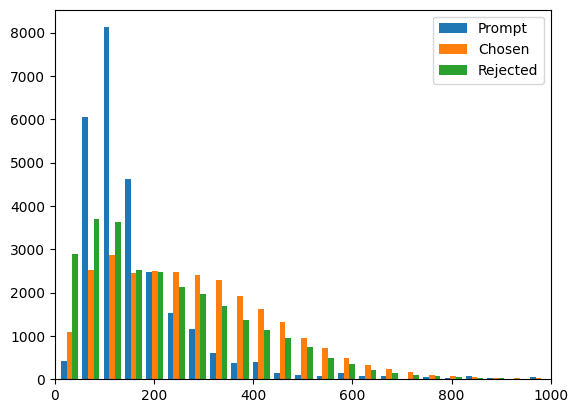

In [18]:
import matplotlib.pyplot as plt

plt.hist([prompt_lens, chosen_lens, rejected_lens], 50, histtype="bar")
plt.legend(["Prompt", "Chosen", "Rejected"])
plt.xlim([0, 1000])
plt.savefig("data_dist.pdf")

In [19]:
from transformers import TrainingArguments
from datasets import Dataset
from trl import DPOTrainer

training_args = TrainingArguments(
    per_device_train_batch_size=1,
    learning_rate=5e-5,
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    gradient_accumulation_steps=1,
    logging_steps=10,
    eval_steps=500,
    optim="adamw_torch_fused",
    warmup_ratio=0.1,
    max_grad_norm=0.3,
    output_dir="logs",
    remove_unused_columns=False,
    push_to_hub=False,
    report_to="tensorboard",
)

tokenizer.pad_token = tokenizer.eos_token

ds_loaded = Dataset.from_json("datasets/dpo_hf_dataset.json")
ds_loaded = ds_loaded.train_test_split(test_size=0.2)

trainer = DPOTrainer(
    base_model,# peft_model,
    # ref_model,# ref_peft_model,
    args=training_args,
    train_dataset=ds_loaded["train"],
    eval_dataset=ds_loaded["test"],
    tokenizer=tokenizer,
    peft_config=lora_config,
    max_prompt_length=512,
    max_length=1024,
    beta=0.1,
    loss_type="robust",
    # precompute_ref_log_probs=True,
    # callbacks=[RichProgressCallback] if TRL_USE_RICH else None,
)

/home/toskov/project-code-2024/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': max_prompt_length, max_length, loss_type. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in DPOTrainer, please use the DPOConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)


AttributeError: 'TrainingArguments' object has no attribute 'model_init_kwargs'

In [ ]:
trainer.train()

Train dataset reference log probs:   0%|          | 0/21390 [00:00<?, ?it/s]

KeyboardInterrupt: 